# Gini-to-Fourier Analysis Example 

This notebook makes use of the Crypto data in the G-Research Crypto Dataset ("G-Research_TrainData.csv" in Crypto Folder)

The package `GSFU` references the GSFU.py file in the shared drive, this file contains the definitions for the functions that are imported to do the general parts of the analysis

<BR>

**Any notebook that calls the GSFU library needs to have the GFSU.py file in its path, so either put new notebook in the same folder or copy GSFU.py to the folder you are working in**

*if on colab may need to mount the drive and change directory so that GFSU.py is accessible

To get to Project Folder in colab follow the following 3 code cells:



In [5]:
from google.colab import drive 
drive.mount('/content/drive') #mount your colab notebook onto your google drive filesystem

Mounted at /content/drive


In [7]:
# Change directory to the Gini Project folder -- might be different per user, can use the `Files` tab in left hand menu to look visually
!cd "/content/drive/MyDrive/Gini Spectral Fourier Data Quality project" 


/content/drive/.shortcut-targets-by-id/1HK4IIdQ8uwDV5XhlWPEB0s6mbi3Ai9Pl/Gini Spectral Fourier Data Quality project


In [8]:
# Verify you navigated into the correct directory with this command, output should be the same as this
# run `!ls` in a separate code block! (use this output to verify in same place)
!ls

 911_Seasonality.ipynb		'Final Presentation Slides'
 AmazonReviewDatasets.txt	 GeneralProcess.ipynb
'Amazon Reviews - CKG'		 Gini_Calculation
 Crypto				'GINI_PROF_PX example.R'
 CryptoExample-GSFU.ipynb	 GINI_PROF_PX.R
 Data.csv			 GSFU.py
'Data Quality (Stocks)'		'Model Notebook'
 Deprecated			'New Datasets - not yet classified'
 FFT_Python			 pareto_query_sample.txt
'FFT w Gini Time Series.ipynb'	 __pycache__


In [ ]:
# General Imports
import pandas as pd 
import numpy as np 
from GSFU import *

# Supress MatPlotLib Axes Warning (non-detrimental, can remove and will just get extra text)
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)


# Read In Dataset -- directly into a pandas dataframe
df = pd.read_csv("Crypto/G-Research_TrainData.csv") #CKG had to do some massaging to the data from the original source, try to do a thorough EDA before diving into the Gini-Fourier analysis

# View df after reading in
df

#### EDA for G-Research Crypto Data
EDA Information:

- Date range for this set is 2018-01-01 to 2021-09-21
- In Raw Data, 'timestamp' is a unixtime second value, we can convert this to a pandas datetime object with the below and apply other operations using it

Because the data is in UnixTime seconds, we need to convert it to a datetime for our GSFU functions -- Below has some sample code to do that in pandas given a Unix timestamp



In [ ]:
# Check Timestamp Intervals -- Unix Seconds
df["timestamp"] = pd.to_datetime(df['timestamp'], unit='s') #might be a different unit with different types of data: [ms, s, m, h, etc.]

# Convert timestamp to DateTime -- Actual Date in format we use for study
df["datetime"] = (pd.to_datetime(df["timestamp"], unit='s').dt.strftime('%Y-%m-%d')) #.dt.strftime cuts off seconds portion of timestamp


In [ ]:
# Get Date Range for Dataset
print(df["timestamp"].min(), df["timestamp"].max()) 

2018-01-01 00:01:00 2021-09-21 00:00:00


In [ ]:
# Verify Changes in DataFrame -- timestamp has been converted & we have new datetime column in format we like
df

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,datetime
0,2018-01-01 00:01:00,2,40.0,2376.580000,2399.500000,2357.140000,2374.590000,1.923301e+01,2373.116392,2018-01-01
1,2018-01-01 00:01:00,0,5.0,8.530000,8.530000,8.530000,8.530000,7.838000e+01,8.530000,2018-01-01
2,2018-01-01 00:01:00,1,229.0,13835.194000,14013.800000,13666.110000,13850.176000,3.155006e+01,13827.062093,2018-01-01
3,2018-01-01 00:01:00,5,32.0,7.659600,7.659600,7.656700,7.657600,6.626713e+03,7.657713,2018-01-01
4,2018-01-01 00:01:00,7,5.0,25.920000,25.920000,25.874000,25.877000,1.210873e+02,25.891363,2018-01-01
...,...,...,...,...,...,...,...,...,...,...
26251913,2021-09-21 00:00:00,9,775.0,157.181571,157.250000,156.700000,156.943857,4.663725e+03,156.994319,2021-09-21
26251914,2021-09-21 00:00:00,10,34.0,2437.065067,2438.000000,2430.226900,2432.907467,3.975460e+00,2434.818747,2021-09-21
26251915,2021-09-21 00:00:00,13,380.0,0.091390,0.091527,0.091260,0.091349,2.193732e+06,0.091388,2021-09-21
26251916,2021-09-21 00:00:00,12,177.0,0.282168,0.282438,0.281842,0.282051,1.828508e+05,0.282134,2021-09-21


In [ ]:
# Aggregate Daily Values (Average for each categorical per day, data is more granular than daily so we aggregate)

# Set DateTime val as index & Group by Day (use average as aggregation function)
dft = df[["datetime", "Asset_ID", "Volume"]] #these three columns represent our: Date, Categorical and Numeric values (investigating gini distribution of some categorical using it's numeric values over time)
dft.groupby(['datetime', "Asset_ID"]).mean() #view


Volume
datetime   Asset_ID              
2018-01-01 0         4.649221e+02
           1         4.018279e+01
           2         1.619305e+01
           5         1.348277e+03
           6         1.901573e+02
...                           ...
2021-09-21 9         4.663725e+03
           10        3.975460e+00
           11        1.035123e+02
           12        1.828508e+05
           13        2.193732e+06

[18102 rows x 1 columns]

The output above showcases the data with unique dates as index and then each asset's average Volume for the given day, if we look at "dft" we see the following:

In [ ]:
dft #each datetime is stored as a separate column, this type of dataframe (these 3 types of columns) is what we typically pass as input to the `giniCalculation` function

,datetime,Asset_ID,Volume
0,2018-01-01,2,1.923301e+01
1,2018-01-01,0,7.838000e+01
2,2018-01-01,1,3.155006e+01
3,2018-01-01,5,6.626713e+03
4,2018-01-01,7,1.210873e+02
...,...,...,...
26251913,2021-09-21,9,4.663725e+03
26251914,2021-09-21,10,3.975460e+00
26251915,2021-09-21,13,2.193732e+06
26251916,2021-09-21,12,1.828508e+05


#### Apply GSFU Functions

Open the `GSFU.py` file to view the actual functions, here we look at the usage of them

In [ ]:
# Make Sure DateTime in uninterupted -- it is (this function prints out information whilst checking whether or not a date sequence is interupted)
checkSequence(df=dft, date="datetime" #pass in the pandas dataframe and name of date column here
            , sequence_type="7-Day" #Possible Values are: ["7-Day", "5-Day"] for full and business weeks - crypto has no off days, so we choose `7-Day`
            , print_missing=False) #if print_missing=True, then it will print out any missing dates in sequence

# This function returns the uninterupted sequence (as a pandas series object) and the missing dates in a list
# Returning those values would look like this -- uncomment below line to run w return
#uninterupted_sequence, missing_dates = checkSequence(df=dft, date="datetime", sequence_type="7-Day", print_missing=False)

# of Dates in UninterruptedSequence: 1360
       # of Dates in ActualSequence: 1360

# of Missing Dates: 0


(DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
                '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
                '2018-01-09', '2018-01-10',
                ...
                '2021-09-12', '2021-09-13', '2021-09-14', '2021-09-15',
                '2021-09-16', '2021-09-17', '2021-09-18', '2021-09-19',
                '2021-09-20', '2021-09-21'],
               dtype='datetime64[ns]', length=1360, freq='D'),
 [])

In [ ]:
# Try Gini Out -- with fastest Gini Calculator, still takes 38.5min to run on Crypto Data
df_ginis = calculateGinis(df=dft #pandas dateframe with columns in it
                , datetime="datetime" #colname for dates data
                , numeric="Volume" #colname for numeric data
                , return_df=True #if true, returns a pandas dataframe, else it will return a python dict (sorted by date)
                , impute_prior_day=True) #if true, will impute the prior day value for any NaNs in array, if false will leave NaNs as is
df_ginis

,DATE,GINI
0,2018-01-01,0.778787
1,2018-01-02,0.763948
2,2018-01-03,0.759484
3,2018-01-04,0.790427
4,2018-01-05,0.758523
...,...,...
1355,2021-09-17,0.904830
1356,2021-09-18,0.877746
1357,2021-09-19,0.886926
1358,2021-09-20,0.883418


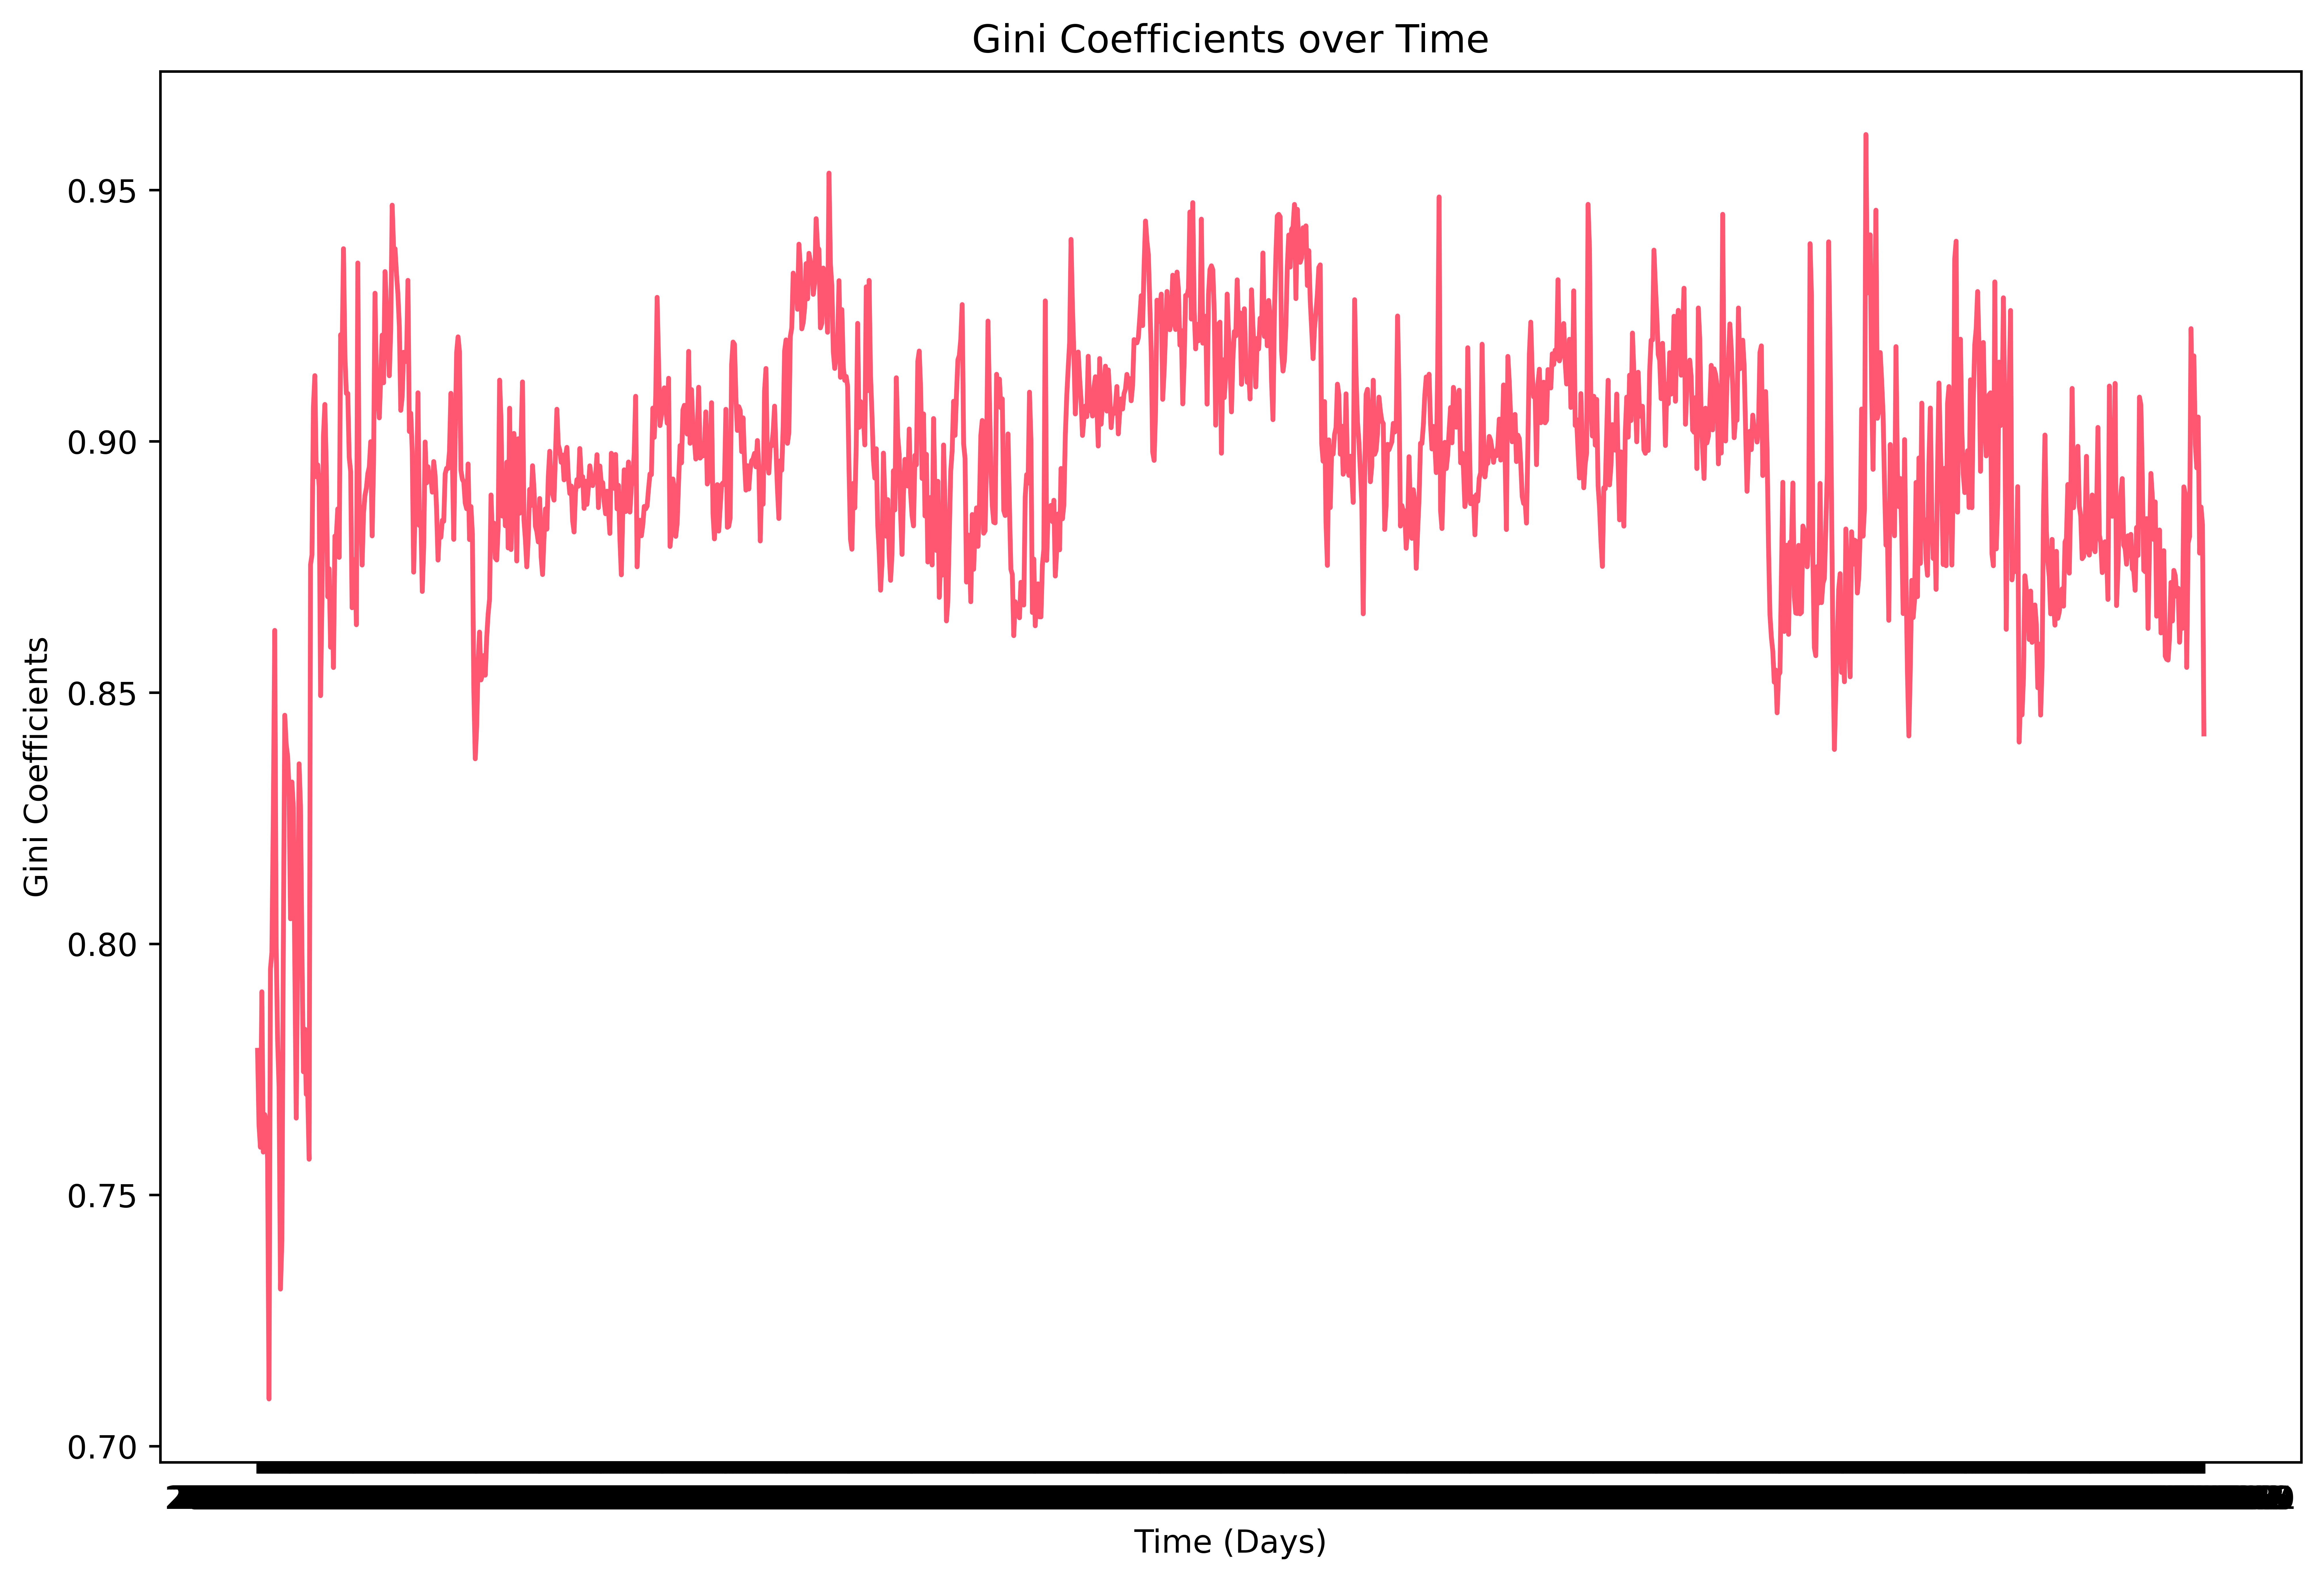

In [ ]:
# Plot out Gini Distribution over Time -- sharp increase likely relates to Bitcoin rise, need to potentially normalize or filter the range somehow?
plotGinis(df=df_ginis #df with columns specified below
        , dates="DATE" #colname for date
        , ginis="GINI" #colname for gini
        , line_color="#FF5671", x_label="Time (Days)", y_label="Gini Coefficients", title="Gini Coefficients over Time") #MatPlotLib Plot Parameters

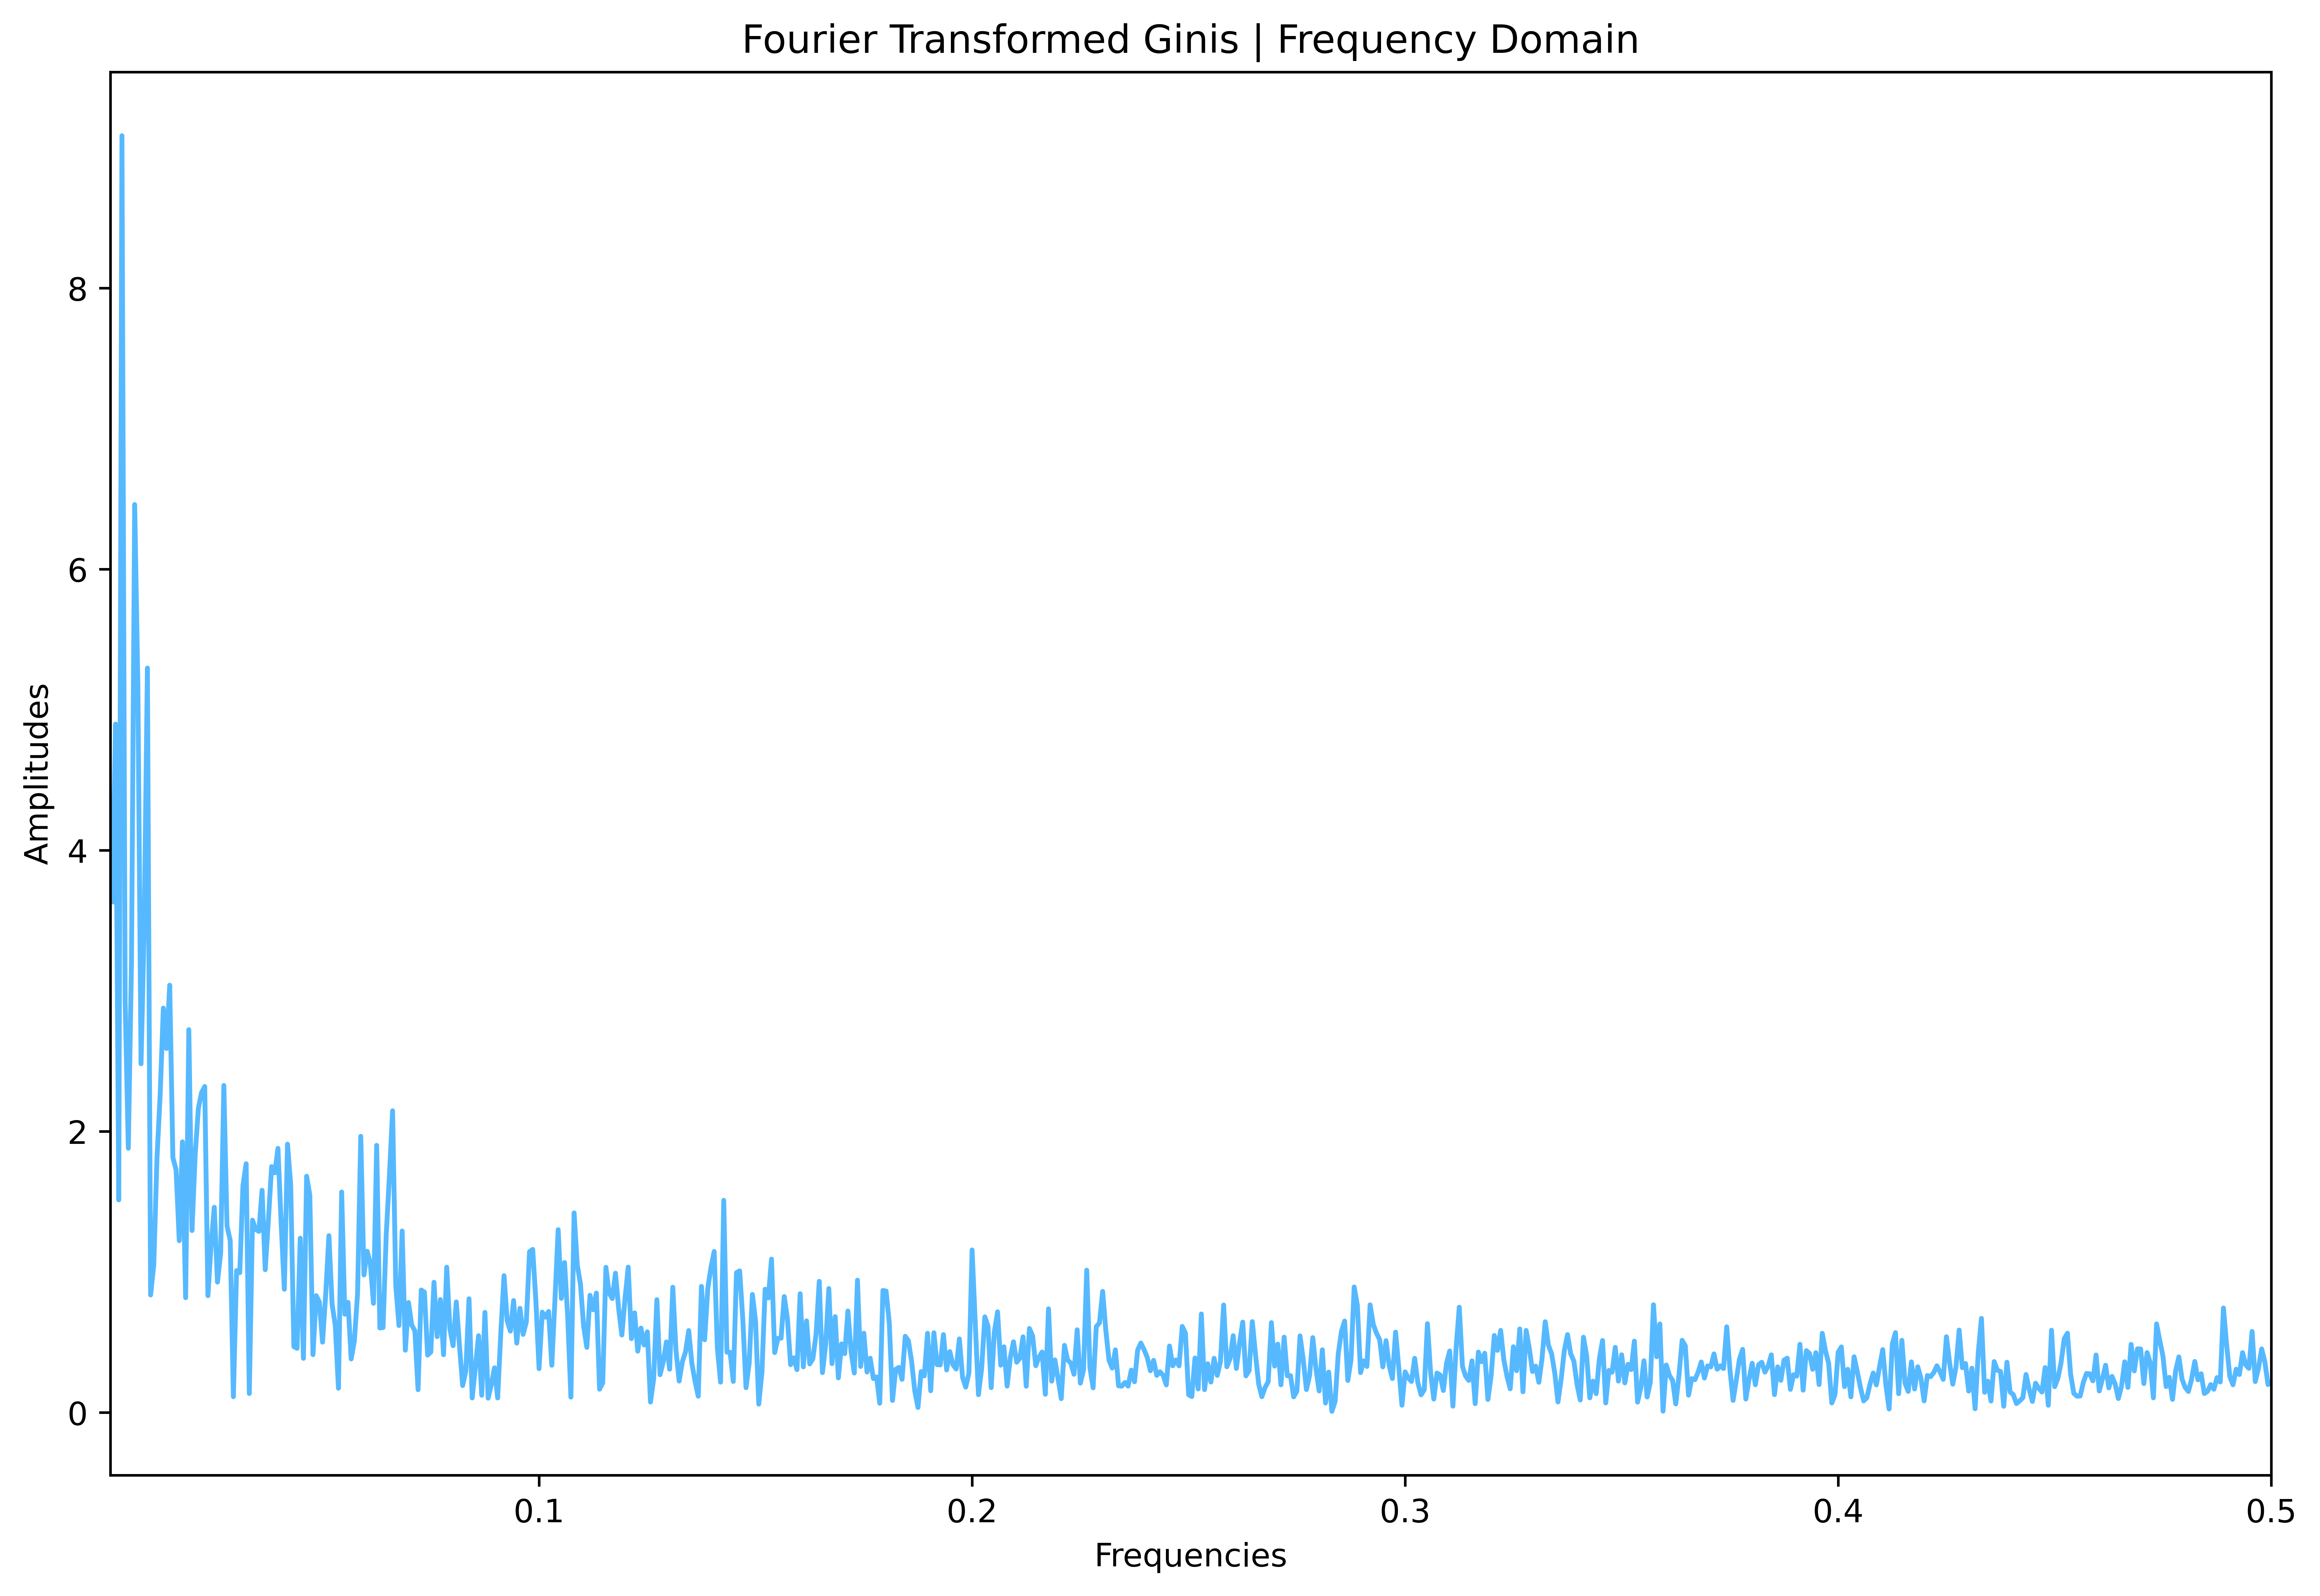

In [ ]:
# Plot the Fourier Sequence
plotFourier(gini_array=df_ginis["GINI"].to_numpy()
            , mask_threshold=0.001 #value to filter out noise with, typically around 0.01 or 0.001 (masks any values less than this threshold out)
            , x_axis_range=(0.001, 0.5) #filter the axis to zoom in and out, rfft returns positive only frequencies lower than 0.5 (so range should be between 0 & 0.5)
            , line_color="#56B9FF", x_label="Frequencies", y_label="Amplitudes", title="Fourier Transformed Ginis | Frequency Domain") #MatPlotLib Plot Parameters


The above codeblock allows a user to investigate different portions of the Gini Dataframe in the Frequency domain, it calculates the Fouriers on each run and plots the output, you could use this to go back and make changes to the underlying data (limiting the range based on Gini Coefficients) or as a basis for investigating something further 


In [ ]:
# Get Frequency & Fourier Values for the Gini df -- if wanted the array of Fourier Values
freqs, fouriers = getFouriers(df_ginis["GINI"]
                            , mask_threshold=0) #mask_threshold refers to the value used to mask out any noise (values in Frequency domain close to zero are likely not noise)
